In [1]:
func_dir = '/global/home/users/ann_scheliga/CYGNSS-GRACE/codebase/'

In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append(func_dir)
import load_data
import time_series_calcs

In [3]:
fw = load_data.load_CYGNSS_05()
grace_dict = load_data.load_GRACE()

In [4]:
def grace_point_subset(coords_i):
    """
    Inputs
    ------
    coords_i: tuple of (lat,lon)
    
    Outputs
    -------
    cmwe_i: pd.DataFrame
        GRACE cmwe solution of the mascon containing the input point
    mascon_i: pd.DataFrame
        GRACE mascon metadata of the mascon containing the input point
    
    """
    lat = coords_i[0]
    lon = coords_i[1]
    # Check if within longitude range
    lat_max = grace_dict['mascon']['lat_center'] + grace_dict['mascon']['lat_span']/2
    lat_min = grace_dict['mascon']['lat_center'] - grace_dict['mascon']['lat_span']/2
    lat_range = (lat>=lat_min) * (lat <= lat_max)
    # Check if within latitude range
    lon_max = grace_dict['mascon']['lon_center'] + grace_dict['mascon']['lon_span']/2
    lon_min = grace_dict['mascon']['lon_center'] - grace_dict['mascon']['lon_span']/2
    lon_range = (lon>=lon_min) * (lon <= lon_max)
    
    range_bool = lat_range * lon_range
    
    mascon_i = grace_dict['mascon'].loc[range_bool]
    cmwe_i = grace_dict['cmwe'].loc[mascon_i.index].squeeze()
    return cmwe_i , mascon_i

In [5]:
def cygnss_point_subset(coords_i):
    fw_xr = fw.sel(lat=coords_i[0],lon=coords_i[1],method='nearest')
    dates_fw = np.array(list(map(lambda x: pd.Timestamp('2018-08-01') + pd.DateOffset(months=x),fw_xr['time'])))
    fw_ts = pd.Series(data=fw_xr,index=dates_fw)
    return fw_ts

In [6]:
def intersecting_timeframes(series1,series2,buffer=1):
    series1_start = series1.index.min() + pd.DateOffset(months=-buffer)
    series1_stop  = series1.index.max() + pd.DateOffset(months= buffer)
    series2_start = series2.index.min() + pd.DateOffset(months=-buffer)
    series2_stop  = series2.index.max() + pd.DateOffset(months= buffer)
    
    series1_intersect = series1.loc[(series1.index>=series2_start) & (series1.index<=series2_stop)]
    series2_intersect = series2.loc[(series2.index>=series1_start) & (series2.index<=series1_stop)]
    
    return series1_intersect , series2_intersect

In [46]:
def single_timeseries_GRACE_CYGNSS(coords_i):
    """
    Inputs
    ------
    coords_i: tuple of (lat,lon)
    
    Outputs
    -------
    
    """
    fw_full = cygnss_point_subset(coords_i)
    cmwe_full , mascon_ts = grace_point_subset(coords_i)
    
    fw_ts , cmwe_ts = intersecting_timeframes(fw_full,cmwe_full)
    
    plt.figure(figsize=(12,6))
    
    ax1 = fw_ts.plot(label='CYGNSS',legend=True)
    ax2 = cmwe_ts.plot(ax=ax1,secondary_y = True,label='GRACE',legend=True, color = 'k')
    
    ax1.set_ylabel('Fraction of water coverage')
    ax2.set_ylabel('water equivalence (cm)')
    return fw_ts , cmwe_ts

In [ ]:
merowe = (18.68 , 32.06)
indirasagar = (22.18,76.6)

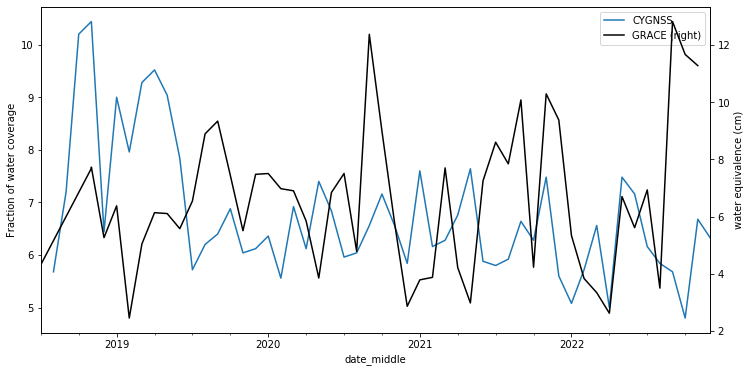

In [48]:
fw_series , cmwe_series = single_timeseries_GRACE_CYGNSS(merowe)

In [25]:
from datetime import datetime as dt
import time

def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = dt(year=year, month=1, day=1)
    startOfNextYear = dt(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction
fw_ts.index = list(map(toYearFraction,fw_series.index))
cmwe_ts.index = list(map(toYearFraction,cmwe_series.index))

In [26]:
fw_ts = time_series_calcs.TimeSeriesMetrics(fw_ts,'CYGNSS')
cmwe_ts = time_series_calcs.TimeSeriesMetrics(cmwe_ts,'GRACE')

In [37]:
len(fw_ts.ts) , len(cmwe_ts.ts)

(53, 51)

In [34]:
fw_ts.cross_corr(cmwe_ts.ts)

AssertionError: Mismatch in length of time series